In [23]:
import numpy as np
import os
# %matplotlib notebook
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

In [15]:
all_angles = np.load("./circular_motion/all_angles.npy")
sin_angles = np.sin(all_angles)
ids = np.load("/home/dmi/neural-state-variables/scripts/logs_circular_motion_refine-64_1/variables/ids.npy")
raw_vars = np.load("/home/dmi/neural-state-variables/scripts/logs_circular_motion_refine-64_1/variables/refine_latent.npy")
print(ids.shape)
print(raw_vars.shape)
print(all_angles.shape)

(6270,)
(6270, 2)
(1100, 60)


In [16]:
angles = all_angles[524]
angles = angles[3:] # Ignor 
var1 = raw_vars[:57, 0]
var2 = raw_vars[:57, 1]

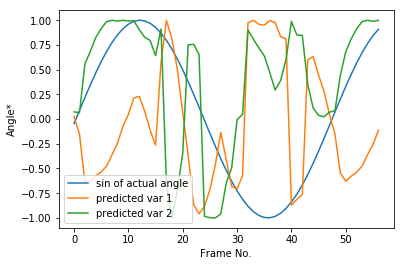

In [17]:
plt.plot(np.sin(angles), label='sin of actual angle')
plt.plot(var1, label='predicted var 1')
plt.plot(var2, label='predicted var 2')
# plt.plot(np.sin(var1))
# plt.plot(np.sin(var2))
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.show()

# Neural Net
## Source: https://github.com/christianversloot/machine-learning-articles/blob/main/creating-a-multilayer-perceptron-with-pytorch-and-lightning.md

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train_vars = []
train_angles = []
train_ids = []

curr_id = -1
for i in range(0, len(ids), 57):
    set_id = int(ids[i].split("_")[0])
    a = all_angles[set_id][3:]
    v = raw_vars[i:i+57]
    
    train_ids.append(set_id)
    train_angles.append(a)
    train_vars.append(v)


In [21]:
X = np.array(train_vars)
y = np.array(train_angles)
train_ids = np.array(train_ids)
print(train_ids.shape)
print(np.array(X).shape)
print(np.array(y).shape)

(110,)
(110, 57, 2)
(110, 57)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()
print(X_train[0].shape)
print(y_train[0].shape)

(108, 57, 2)
(108, 57)
(2, 57, 2)
(2, 57)
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([108, 57, 2])
torch.Size([108, 57])
torch.Size([2, 57, 2])
torch.Size([2, 57])

torch.Size([57, 2])
torch.Size([57])


In [41]:
class MLP_large(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

class MLP_medium(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

class MLP_small(nn.Module):
    '''
    Multilayer Perceptron.
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [48]:
# TRAINING

# HYPERPARAMETERS
epochs = 500
learn_rate = 0.001

# Set fixed random number seed
torch.manual_seed(42)

# Initialize the MLP
mlp_small = MLP_small()
mlp_medium = MLP_medium()
mlp_large = MLP_large()

models = [mlp_small, mlp_medium, mlp_large]
epoch_schedule = [10, 100, 500]

# Define the loss function and optimizer
loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=learn_rate)
# optimizer = torch.optim.SGD(mlp.parameters(), lr=learn_rate)

# Run the training loop
for epoch in range(0, epochs):

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i in range(len(X_train)):

      # Get inputs
#       inputs, targets = data
        inputs = X_train[i]
        targets = y_train[i].view(57,-1)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)
        
#         print("inputs:", inputs.shape)
#         print('targets:', targets.shape)
#         print("outputs:", outputs.shape)
        
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 9:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 10))
            current_loss = 0.0
        

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch    10: 57.424
Loss after mini-batch    20: 47.408
Loss after mini-batch    30: 43.331
Loss after mini-batch    40: 32.601
Loss after mini-batch    50: 50.308
Loss after mini-batch    60: 39.202
Loss after mini-batch    70: 47.884
Loss after mini-batch    80: 35.038
Loss after mini-batch    90: 30.135
Loss after mini-batch   100: 32.282
Starting epoch 2
Loss after mini-batch    10: 27.676
Loss after mini-batch    20: 21.387
Loss after mini-batch    30: 18.454
Loss after mini-batch    40: 12.629
Loss after mini-batch    50: 22.363
Loss after mini-batch    60: 16.346
Loss after mini-batch    70: 20.748
Loss after mini-batch    80: 14.482
Loss after mini-batch    90: 12.238
Loss after mini-batch   100: 12.918
Starting epoch 3
Loss after mini-batch    10: 11.746
Loss after mini-batch    20: 9.719
Loss after mini-batch    30: 8.122
Loss after mini-batch    40: 6.933
Loss after mini-batch    50: 10.721
Loss after mini-batch    60: 8.594
Loss after mini-b

Loss after mini-batch    40: 7.439
Loss after mini-batch    50: 8.167
Loss after mini-batch    60: 7.029
Loss after mini-batch    70: 8.287
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.740
Loss after mini-batch   100: 7.200
Starting epoch 24
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.741
Loss after mini-batch    30: 6.849
Loss after mini-batch    40: 7.439
Loss after mini-batch    50: 8.167
Loss after mini-batch    60: 7.029
Loss after mini-batch    70: 8.286
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.739
Loss after mini-batch   100: 7.200
Starting epoch 25
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.741
Loss after mini-batch    30: 6.850
Loss after mini-batch    40: 7.439
Loss after mini-batch    50: 8.168
Loss after mini-batch    60: 7.028
Loss after mini-batch    70: 8.286
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.739
Loss after mini-batch   100: 7.199
Starting epoch 26
L

Loss after mini-batch   100: 7.191
Starting epoch 47
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.734
Loss after mini-batch    30: 6.860
Loss after mini-batch    40: 7.441
Loss after mini-batch    50: 8.166
Loss after mini-batch    60: 7.017
Loss after mini-batch    70: 8.277
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.734
Loss after mini-batch   100: 7.191
Starting epoch 48
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.734
Loss after mini-batch    30: 6.861
Loss after mini-batch    40: 7.442
Loss after mini-batch    50: 8.165
Loss after mini-batch    60: 7.017
Loss after mini-batch    70: 8.277
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.734
Loss after mini-batch   100: 7.190
Starting epoch 49
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.733
Loss after mini-batch    30: 6.861
Loss after mini-batch    40: 7.442
Loss after mini-batch    50: 8.165
Loss after mini-batch    60: 7.016
L

Loss after mini-batch    70: 8.271
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.729
Loss after mini-batch   100: 7.185
Starting epoch 71
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.728
Loss after mini-batch    30: 6.869
Loss after mini-batch    40: 7.447
Loss after mini-batch    50: 8.158
Loss after mini-batch    60: 7.009
Loss after mini-batch    70: 8.270
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.729
Loss after mini-batch   100: 7.184
Starting epoch 72
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.728
Loss after mini-batch    30: 6.869
Loss after mini-batch    40: 7.448
Loss after mini-batch    50: 8.157
Loss after mini-batch    60: 7.008
Loss after mini-batch    70: 8.270
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.729
Loss after mini-batch   100: 7.184
Starting epoch 73
Loss after mini-batch    10: 8.139
Loss after mini-batch    20: 7.728
Loss after mini-batch    30: 6.870
L

Loss after mini-batch    70: 8.265
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.725
Loss after mini-batch   100: 7.180
Starting epoch 94
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.724
Loss after mini-batch    30: 6.877
Loss after mini-batch    40: 7.452
Loss after mini-batch    50: 8.151
Loss after mini-batch    60: 7.002
Loss after mini-batch    70: 8.265
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.725
Loss after mini-batch   100: 7.180
Starting epoch 95
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.724
Loss after mini-batch    30: 6.877
Loss after mini-batch    40: 7.453
Loss after mini-batch    50: 8.150
Loss after mini-batch    60: 7.002
Loss after mini-batch    70: 8.264
Loss after mini-batch    80: 8.353
Loss after mini-batch    90: 7.725
Loss after mini-batch   100: 7.180
Starting epoch 96
Loss after mini-batch    10: 8.140
Loss after mini-batch    20: 7.724
Loss after mini-batch    30: 6.878
L

Loss after mini-batch    20: 7.720
Loss after mini-batch    30: 6.885
Loss after mini-batch    40: 7.457
Loss after mini-batch    50: 8.144
Loss after mini-batch    60: 6.996
Loss after mini-batch    70: 8.260
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.722
Loss after mini-batch   100: 7.176
Starting epoch 119
Loss after mini-batch    10: 8.142
Loss after mini-batch    20: 7.720
Loss after mini-batch    30: 6.885
Loss after mini-batch    40: 7.457
Loss after mini-batch    50: 8.144
Loss after mini-batch    60: 6.996
Loss after mini-batch    70: 8.259
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.722
Loss after mini-batch   100: 7.176
Starting epoch 120
Loss after mini-batch    10: 8.142
Loss after mini-batch    20: 7.720
Loss after mini-batch    30: 6.886
Loss after mini-batch    40: 7.457
Loss after mini-batch    50: 8.144
Loss after mini-batch    60: 6.996
Loss after mini-batch    70: 8.259
Loss after mini-batch    80: 8.352
Loss after mini-b

Loss after mini-batch    30: 6.892
Loss after mini-batch    40: 7.461
Loss after mini-batch    50: 8.138
Loss after mini-batch    60: 6.992
Loss after mini-batch    70: 8.255
Loss after mini-batch    80: 8.352
Loss after mini-batch    90: 7.720
Loss after mini-batch   100: 7.173
Starting epoch 143
Loss after mini-batch    10: 8.144
Loss after mini-batch    20: 7.716
Loss after mini-batch    30: 6.893
Loss after mini-batch    40: 7.461
Loss after mini-batch    50: 8.138
Loss after mini-batch    60: 6.992
Loss after mini-batch    70: 8.255
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.720
Loss after mini-batch   100: 7.173
Starting epoch 144
Loss after mini-batch    10: 8.144
Loss after mini-batch    20: 7.716
Loss after mini-batch    30: 6.893
Loss after mini-batch    40: 7.461
Loss after mini-batch    50: 8.138
Loss after mini-batch    60: 6.991
Loss after mini-batch    70: 8.255
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.720
Loss after mini-b

Loss after mini-batch    90: 7.718
Loss after mini-batch   100: 7.171
Starting epoch 167
Loss after mini-batch    10: 8.146
Loss after mini-batch    20: 7.714
Loss after mini-batch    30: 6.899
Loss after mini-batch    40: 7.464
Loss after mini-batch    50: 8.133
Loss after mini-batch    60: 6.988
Loss after mini-batch    70: 8.251
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.718
Loss after mini-batch   100: 7.171
Starting epoch 168
Loss after mini-batch    10: 8.146
Loss after mini-batch    20: 7.713
Loss after mini-batch    30: 6.899
Loss after mini-batch    40: 7.464
Loss after mini-batch    50: 8.133
Loss after mini-batch    60: 6.988
Loss after mini-batch    70: 8.251
Loss after mini-batch    80: 8.351
Loss after mini-batch    90: 7.718
Loss after mini-batch   100: 7.171
Starting epoch 169
Loss after mini-batch    10: 8.146
Loss after mini-batch    20: 7.713
Loss after mini-batch    30: 6.899
Loss after mini-batch    40: 7.465
Loss after mini-batch    50: 8.13

Loss after mini-batch    10: 8.147
Loss after mini-batch    20: 7.711
Loss after mini-batch    30: 6.904
Loss after mini-batch    40: 7.467
Loss after mini-batch    50: 8.129
Loss after mini-batch    60: 6.985
Loss after mini-batch    70: 8.249
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.717
Loss after mini-batch   100: 7.169
Starting epoch 192
Loss after mini-batch    10: 8.147
Loss after mini-batch    20: 7.711
Loss after mini-batch    30: 6.904
Loss after mini-batch    40: 7.468
Loss after mini-batch    50: 8.128
Loss after mini-batch    60: 6.985
Loss after mini-batch    70: 8.249
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.717
Loss after mini-batch   100: 7.169
Starting epoch 193
Loss after mini-batch    10: 8.147
Loss after mini-batch    20: 7.711
Loss after mini-batch    30: 6.904
Loss after mini-batch    40: 7.468
Loss after mini-batch    50: 8.128
Loss after mini-batch    60: 6.985
Loss after mini-batch    70: 8.248
Loss after mini-b

Loss after mini-batch    50: 8.125
Loss after mini-batch    60: 6.983
Loss after mini-batch    70: 8.247
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.715
Loss after mini-batch   100: 7.168
Starting epoch 216
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.710
Loss after mini-batch    30: 6.907
Loss after mini-batch    40: 7.470
Loss after mini-batch    50: 8.125
Loss after mini-batch    60: 6.983
Loss after mini-batch    70: 8.247
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.715
Loss after mini-batch   100: 7.168
Starting epoch 217
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.710
Loss after mini-batch    30: 6.907
Loss after mini-batch    40: 7.470
Loss after mini-batch    50: 8.124
Loss after mini-batch    60: 6.983
Loss after mini-batch    70: 8.246
Loss after mini-batch    80: 8.350
Loss after mini-batch    90: 7.715
Loss after mini-batch   100: 7.168
Starting epoch 218
Loss after mini-batch    10: 8.14

Loss after mini-batch    30: 6.909
Loss after mini-batch    40: 7.472
Loss after mini-batch    50: 8.121
Loss after mini-batch    60: 6.982
Loss after mini-batch    70: 8.245
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.714
Loss after mini-batch   100: 7.168
Starting epoch 240
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.709
Loss after mini-batch    30: 6.910
Loss after mini-batch    40: 7.473
Loss after mini-batch    50: 8.121
Loss after mini-batch    60: 6.982
Loss after mini-batch    70: 8.245
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.714
Loss after mini-batch   100: 7.168
Starting epoch 241
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.709
Loss after mini-batch    30: 6.910
Loss after mini-batch    40: 7.473
Loss after mini-batch    50: 8.121
Loss after mini-batch    60: 6.982
Loss after mini-batch    70: 8.245
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.713
Loss after mini-b

Loss after mini-batch   100: 7.167
Starting epoch 263
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.709
Loss after mini-batch    30: 6.911
Loss after mini-batch    40: 7.475
Loss after mini-batch    50: 8.118
Loss after mini-batch    60: 6.981
Loss after mini-batch    70: 8.244
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.712
Loss after mini-batch   100: 7.167
Starting epoch 264
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.911
Loss after mini-batch    40: 7.475
Loss after mini-batch    50: 8.117
Loss after mini-batch    60: 6.981
Loss after mini-batch    70: 8.244
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.712
Loss after mini-batch   100: 7.167
Starting epoch 265
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.911
Loss after mini-batch    40: 7.475
Loss after mini-batch    50: 8.117
Loss after mini-batch    60: 6.98

Loss after mini-batch    90: 7.711
Loss after mini-batch   100: 7.166
Starting epoch 286
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.477
Loss after mini-batch    50: 8.114
Loss after mini-batch    60: 6.980
Loss after mini-batch    70: 8.243
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.711
Loss after mini-batch   100: 7.166
Starting epoch 287
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.477
Loss after mini-batch    50: 8.114
Loss after mini-batch    60: 6.980
Loss after mini-batch    70: 8.243
Loss after mini-batch    80: 8.349
Loss after mini-batch    90: 7.711
Loss after mini-batch   100: 7.166
Starting epoch 288
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.477
Loss after mini-batch    50: 8.11

Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.710
Loss after mini-batch   100: 7.166
Starting epoch 310
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.479
Loss after mini-batch    50: 8.111
Loss after mini-batch    60: 6.979
Loss after mini-batch    70: 8.242
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.709
Loss after mini-batch   100: 7.166
Starting epoch 311
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.479
Loss after mini-batch    50: 8.111
Loss after mini-batch    60: 6.979
Loss after mini-batch    70: 8.242
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.709
Loss after mini-batch   100: 7.166
Starting epoch 312
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.708
Loss after mini-batch    30: 6.912
Loss after mini-batch    40: 7.47

Loss after mini-batch    90: 7.708
Loss after mini-batch   100: 7.166
Starting epoch 334
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.481
Loss after mini-batch    50: 8.108
Loss after mini-batch    60: 6.979
Loss after mini-batch    70: 8.241
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.708
Loss after mini-batch   100: 7.166
Starting epoch 335
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.481
Loss after mini-batch    50: 8.108
Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.241
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.708
Loss after mini-batch   100: 7.166
Starting epoch 336
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.481
Loss after mini-batch    50: 8.10

Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.240
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.707
Loss after mini-batch   100: 7.165
Starting epoch 358
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.483
Loss after mini-batch    50: 8.105
Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.240
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.707
Loss after mini-batch   100: 7.165
Starting epoch 359
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.707
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.483
Loss after mini-batch    50: 8.105
Loss after mini-batch    60: 6.978
Loss after mini-batch    70: 8.240
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.707
Loss after mini-batch   100: 7.165
Starting epoch 360
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.70

Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.239
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 382
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.485
Loss after mini-batch    50: 8.101
Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.239
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 383
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.485
Loss after mini-batch    50: 8.101
Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.239
Loss after mini-batch    80: 8.348
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 384
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.70

Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.238
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 406
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.486
Loss after mini-batch    50: 8.098
Loss after mini-batch    60: 6.977
Loss after mini-batch    70: 8.238
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.705
Loss after mini-batch   100: 7.165
Starting epoch 407
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.486
Loss after mini-batch    50: 8.098
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.238
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.704
Loss after mini-batch   100: 7.165
Starting epoch 408
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.70

Starting epoch 428
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.488
Loss after mini-batch    50: 8.096
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.237
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.704
Loss after mini-batch   100: 7.165
Starting epoch 429
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.488
Loss after mini-batch    50: 8.096
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.237
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.704
Loss after mini-batch   100: 7.165
Starting epoch 430
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.706
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.488
Loss after mini-batch    50: 8.096
Loss after mini-batch    60: 6.976
Loss after mini-batch    70: 8.23

Loss after mini-batch    50: 8.094
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.703
Loss after mini-batch   100: 7.165
Starting epoch 451
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.489
Loss after mini-batch    50: 8.094
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.703
Loss after mini-batch   100: 7.165
Starting epoch 452
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.489
Loss after mini-batch    50: 8.094
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.703
Loss after mini-batch   100: 7.165
Starting epoch 453
Loss after mini-batch    10: 8.14

Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.702
Loss after mini-batch   100: 7.165
Starting epoch 475
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.490
Loss after mini-batch    50: 8.092
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.702
Loss after mini-batch   100: 7.165
Starting epoch 476
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.490
Loss after mini-batch    50: 8.092
Loss after mini-batch    60: 6.975
Loss after mini-batch    70: 8.236
Loss after mini-batch    80: 8.347
Loss after mini-batch    90: 7.702
Loss after mini-batch   100: 7.164
Starting epoch 477
Loss after mini-batch    10: 8.148
Loss after mini-batch    20: 7.70

Loss after mini-batch    90: 7.701
Loss after mini-batch   100: 7.164
Starting epoch 497
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.492
Loss after mini-batch    50: 8.089
Loss after mini-batch    60: 6.974
Loss after mini-batch    70: 8.235
Loss after mini-batch    80: 8.346
Loss after mini-batch    90: 7.701
Loss after mini-batch   100: 7.164
Starting epoch 498
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.492
Loss after mini-batch    50: 8.089
Loss after mini-batch    60: 6.974
Loss after mini-batch    70: 8.235
Loss after mini-batch    80: 8.346
Loss after mini-batch    90: 7.701
Loss after mini-batch   100: 7.164
Starting epoch 499
Loss after mini-batch    10: 8.149
Loss after mini-batch    20: 7.705
Loss after mini-batch    30: 6.913
Loss after mini-batch    40: 7.492
Loss after mini-batch    50: 8.08

In [52]:
y_pred = mlp(test_vars).view(57).detach().numpy()
y_true = np.array(angles)
print(y_pred.shape)
print(y_true.shape)

(57,)
(57,)


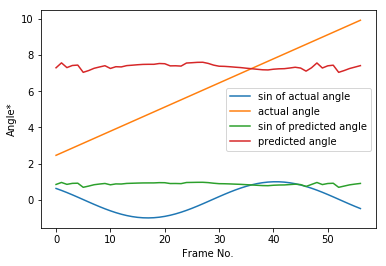

In [53]:
plt.plot(np.sin(y_true), label='sin of actual angle')
plt.plot(y_true, label = 'actual angle')
plt.plot(np.sin(y_pred), label='sin of predicted angle')
plt.plot(y_pred, label='predicted angle')


# plt.plot(var1, label='predicted var 1')
# plt.plot(var2, label='predicted var 2')
# plt.plot(np.sin(var1))
# plt.plot(np.sin(var2))
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.show()

In [36]:
# TESTING
test_vars = X_test[0]
angles = y_test[0]
var1 = test_vars[:, 0]
var2 = test_vars[:, 1]
print(test_vars.shape)
print(angles.shape)
print(var1.shape)
print(var2.shape)

torch.Size([57, 2])
torch.Size([57])
torch.Size([57])
torch.Size([57])


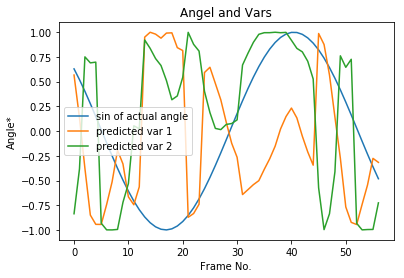

In [37]:
plt.plot(np.sin(angles), label='sin of actual angle')
plt.plot(var1, label='predicted var 1')
plt.plot(var2, label='predicted var 2')
# plt.plot(np.sin(var1))
# plt.plot(np.sin(var2))
plt.xlabel('Frame No.')
plt.ylabel('Angle*')
plt.legend(loc="best")
plt.title("Angel and Vars")
plt.show()

(57,)
(57,)


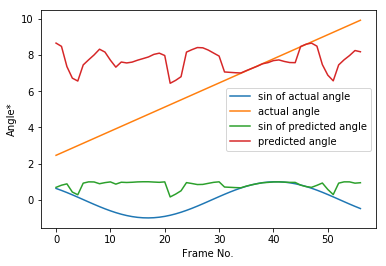

In [ ]:
import os
import torch
from torch import nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2, 32),
      nn.Tanh(),
      nn.Linear(32, 1),
    )
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    return self.layers(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.layers(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return optimizer

In [ ]:
from torchvision.datasets import CIFAR10
dataset = CIFAR10(os.getcwd(), download=True, transform=transforms.ToTensor())
print(type(dataset))
#   pl.seed_everything(42)
#   mlp = MLP()
#   trainer = pl.Trainer(auto_scale_batch_size='power', gpus=0, deterministic=True, max_epochs=5)
#   trainer.fit(mlp, DataLoader(dataset))

In [15]:
# we only have predictions / variables for 1/10 of the training datasets
print(6270/57)

110.0


In [16]:
for i, id in enumerate(ids):
    print(i, id)

0 524_0.png
1 524_1.png
2 524_2.png
3 524_3.png
4 524_4.png
5 524_5.png
6 524_6.png
7 524_7.png
8 524_8.png
9 524_9.png
10 524_10.png
11 524_11.png
12 524_12.png
13 524_13.png
14 524_14.png
15 524_15.png
16 524_16.png
17 524_17.png
18 524_18.png
19 524_19.png
20 524_20.png
21 524_21.png
22 524_22.png
23 524_23.png
24 524_24.png
25 524_25.png
26 524_26.png
27 524_27.png
28 524_28.png
29 524_29.png
30 524_30.png
31 524_31.png
32 524_32.png
33 524_33.png
34 524_34.png
35 524_35.png
36 524_36.png
37 524_37.png
38 524_38.png
39 524_39.png
40 524_40.png
41 524_41.png
42 524_42.png
43 524_43.png
44 524_44.png
45 524_45.png
46 524_46.png
47 524_47.png
48 524_48.png
49 524_49.png
50 524_50.png
51 524_51.png
52 524_52.png
53 524_53.png
54 524_54.png
55 524_55.png
56 524_56.png
57 1032_0.png
58 1032_1.png
59 1032_2.png
60 1032_3.png
61 1032_4.png
62 1032_5.png
63 1032_6.png
64 1032_7.png
65 1032_8.png
66 1032_9.png
67 1032_10.png
68 1032_11.png
69 1032_12.png
70 1032_13.png
71 1032_14.png
72 1032

1859 12_35.png
1860 12_36.png
1861 12_37.png
1862 12_38.png
1863 12_39.png
1864 12_40.png
1865 12_41.png
1866 12_42.png
1867 12_43.png
1868 12_44.png
1869 12_45.png
1870 12_46.png
1871 12_47.png
1872 12_48.png
1873 12_49.png
1874 12_50.png
1875 12_51.png
1876 12_52.png
1877 12_53.png
1878 12_54.png
1879 12_55.png
1880 12_56.png
1881 1005_0.png
1882 1005_1.png
1883 1005_2.png
1884 1005_3.png
1885 1005_4.png
1886 1005_5.png
1887 1005_6.png
1888 1005_7.png
1889 1005_8.png
1890 1005_9.png
1891 1005_10.png
1892 1005_11.png
1893 1005_12.png
1894 1005_13.png
1895 1005_14.png
1896 1005_15.png
1897 1005_16.png
1898 1005_17.png
1899 1005_18.png
1900 1005_19.png
1901 1005_20.png
1902 1005_21.png
1903 1005_22.png
1904 1005_23.png
1905 1005_24.png
1906 1005_25.png
1907 1005_26.png
1908 1005_27.png
1909 1005_28.png
1910 1005_29.png
1911 1005_30.png
1912 1005_31.png
1913 1005_32.png
1914 1005_33.png
1915 1005_34.png
1916 1005_35.png
1917 1005_36.png
1918 1005_37.png
1919 1005_38.png
1920 1005_39.png


3803 681_41.png
3804 681_42.png
3805 681_43.png
3806 681_44.png
3807 681_45.png
3808 681_46.png
3809 681_47.png
3810 681_48.png
3811 681_49.png
3812 681_50.png
3813 681_51.png
3814 681_52.png
3815 681_53.png
3816 681_54.png
3817 681_55.png
3818 681_56.png
3819 247_0.png
3820 247_1.png
3821 247_2.png
3822 247_3.png
3823 247_4.png
3824 247_5.png
3825 247_6.png
3826 247_7.png
3827 247_8.png
3828 247_9.png
3829 247_10.png
3830 247_11.png
3831 247_12.png
3832 247_13.png
3833 247_14.png
3834 247_15.png
3835 247_16.png
3836 247_17.png
3837 247_18.png
3838 247_19.png
3839 247_20.png
3840 247_21.png
3841 247_22.png
3842 247_23.png
3843 247_24.png
3844 247_25.png
3845 247_26.png
3846 247_27.png
3847 247_28.png
3848 247_29.png
3849 247_30.png
3850 247_31.png
3851 247_32.png
3852 247_33.png
3853 247_34.png
3854 247_35.png
3855 247_36.png
3856 247_37.png
3857 247_38.png
3858 247_39.png
3859 247_40.png
3860 247_41.png
3861 247_42.png
3862 247_43.png
3863 247_44.png
3864 247_45.png
3865 247_46.png
38

5306 545_5.png
5307 545_6.png
5308 545_7.png
5309 545_8.png
5310 545_9.png
5311 545_10.png
5312 545_11.png
5313 545_12.png
5314 545_13.png
5315 545_14.png
5316 545_15.png
5317 545_16.png
5318 545_17.png
5319 545_18.png
5320 545_19.png
5321 545_20.png
5322 545_21.png
5323 545_22.png
5324 545_23.png
5325 545_24.png
5326 545_25.png
5327 545_26.png
5328 545_27.png
5329 545_28.png
5330 545_29.png
5331 545_30.png
5332 545_31.png
5333 545_32.png
5334 545_33.png
5335 545_34.png
5336 545_35.png
5337 545_36.png
5338 545_37.png
5339 545_38.png
5340 545_39.png
5341 545_40.png
5342 545_41.png
5343 545_42.png
5344 545_43.png
5345 545_44.png
5346 545_45.png
5347 545_46.png
5348 545_47.png
5349 545_48.png
5350 545_49.png
5351 545_50.png
5352 545_51.png
5353 545_52.png
5354 545_53.png
5355 545_54.png
5356 545_55.png
5357 545_56.png
5358 912_0.png
5359 912_1.png
5360 912_2.png
5361 912_3.png
5362 912_4.png
5363 912_5.png
5364 912_6.png
5365 912_7.png
5366 912_8.png
5367 912_9.png
5368 912_10.png
5369 91

In [8]:
df = np.load('./scripts/logs_circular_motion_refine-64_1/prediction_long_term/model_rollout/stability.npy')

In [9]:
print(df.shape)

(110, 29)


In [10]:
print(df)

[[0.42513606 0.12511013 0.0691979  ... 0.14652    0.0741086  0.05749899]
 [0.1488189  0.05255614 0.15649796 ... 0.05777638 0.15448833 0.04506393]
 [0.29985631 0.48760211 0.06594243 ... 0.04212693 0.14640474 0.07417089]
 ...
 [0.78958726 0.25922719 0.06898575 ... 0.14404491 0.07414602 0.05723037]
 [0.00244545 0.06084003 0.15224837 ... 0.15528372 0.07005972 0.05682437]
 [0.42513606 0.12511013 0.0691979  ... 0.14650923 0.0741182  0.05752001]]


In [16]:
min_loss = 1
min_row = 0
for row in range(df.shape[0]):
    print((row, df[row].mean()))
    if df[row][1] < min_loss:
        min_loss = df[row][1]
        min_row = row
print("MIN LOSS:", min_loss)

(0, 0.10505335392623112)
(1, 0.09304515381568465)
(2, 0.1132471827139821)
(3, 0.14390959120194974)
(4, 0.13637843291307317)
(5, 0.20561725055349284)
(6, 0.18488461795114464)
(7, 0.19127198488547884)
(8, 0.1554230622433383)
(9, 0.18371454163871961)
(10, 0.18580425090301012)
(11, 0.09149181823535212)
(12, 0.13556192866687117)
(13, 0.09441721237039771)
(14, 0.1731555826383932)
(15, 0.1000971877626304)
(16, 0.13673823532359353)
(17, 0.15543689899917307)
(18, 0.10918756391339261)
(19, 0.13151740925065403)
(20, 0.25501897523243877)
(21, 0.10748059147615628)
(22, 0.33525788472515755)
(23, 0.16083988182021883)
(24, 0.209204011243479)
(25, 0.17377800982573938)
(26, 0.19308869463616404)
(27, 0.14709117005033226)
(28, 0.1598863582174968)
(29, 0.19082108666670733)
(30, 0.09164333390071988)
(31, 0.13670430473726372)
(32, 0.09222803727306168)
(33, 0.15505133777985286)
(34, 0.09346123502172272)
(35, 0.10676789001144212)
(36, 0.12039040799798637)
(37, 0.2019957271886283)
(38, 0.2025947998566874)
(39, 

In [17]:
df2 = np.load('./scripts/logs_circular_motion_refine-64_1/prediction_long_term/model_rollout/stability.npy')
print(df2)

[[6.62070420e-03 8.07788316e-03 6.82267360e-03 ... 4.10123542e-03
  7.90984277e-03 1.31637296e-02]
 [2.43708715e-02 9.61202569e-03 6.23096433e-03 ... 3.87154178e-05
  3.66344932e-03 2.37392783e-02]
 [5.76618419e-04 3.10558230e-01 6.49203639e-03 ... 6.34848839e-03
  5.98904584e-03 4.40476742e-03]
 ...
 [2.09539030e-02 3.18954291e-04 3.26922489e-03 ... 1.31643396e-02
  1.73229969e-03 1.71233190e-03]
 [1.50859989e-02 2.40099765e-02 1.37103759e-02 ... 5.48589509e-03
  5.31311287e-03 3.55629460e-03]
 [2.91154999e-03 1.11628510e-02 1.35039296e-02 ... 9.02833417e-03
  5.46923792e-03 5.30208042e-03]]


In [18]:
for row in range(df2.shape[0]):
    print((row, df2[row].mean()))

(0, 0.06849647583570412)
(1, 0.026353803897203258)
(2, 0.02989199457505461)
(3, 0.0314520387320703)
(4, 0.0671243054655798)
(5, 0.027034160765369648)
(6, 0.044627829473248656)
(7, 0.0601645556930164)
(8, 0.034953424818954304)
(9, 0.03425379689737195)
(10, 0.03476493299767126)
(11, 0.06015650049906479)
(12, 0.0314538732686899)
(13, 0.07099552394983816)
(14, 0.0369051683787959)
(15, 0.03874724636889055)
(16, 0.040187821220727)
(17, 0.02331854179320889)
(18, 0.03499048736105986)
(19, 0.09587133217879956)
(20, 0.03969853247038153)
(21, 0.03693359646623039)
(22, 0.07841230282190673)
(23, 0.06799566594217422)
(24, 0.034690360794323576)
(25, 0.026201799452949138)
(26, 0.025683638684783766)
(27, 0.03576341167429526)
(28, 0.041002622259525355)
(29, 0.030749218468152886)
(30, 0.07840881128153153)
(31, 0.03693285600456875)
(32, 0.04143507220635064)
(33, 0.03483885072700073)
(34, 0.036906702303957865)
(35, 0.046459633963893104)
(36, 0.08988033314669557)
(37, 0.059013721020352836)
(38, 0.0625127132